In [1]:
import torch
import json
import os
import csv
from transformers import MixtralForCausalLM

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"
### from path.json read paths of model and dataset
model_name = "mixtral"
dataset_name = "c4"
with open('./path.json', 'r') as file:
    paths = json.load(file)
    model_path = paths.get(model_name, '')
    dataset_path = paths.get(dataset_name, '')
    save_path = paths.get('chess_up_threshold','')
    print('model path:', model_path, '\ndataset path:', dataset_path, '\nsave path:', save_path)

def get_model(model_path):
    model = MixtralForCausalLM.from_pretrained(
        model_path,
        device_map='auto',
        use_cache=False,
        torch_dtype=torch.bfloat16,
        # attn_implementation="flash_attention_2"
    )
    return model
model = get_model(model_path)


/home/lz/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model path: /home/lz/Mixtral-8x7B-v0.1 
dataset path: /home/lz/c4 
save path: /home/lz/On-the-Fly_MoE_Inference/saving/threshold/c4_mixtral_up


Loading checkpoint shards: 100%|██████████| 19/19 [00:34<00:00,  1.81s/it]


In [2]:
from convert_model import convert_mixtral_model

convert_mixtral_model(model, start_num=-1, end_num=32, gamma=0.2)

/home/lz/On-the-Fly_MoE_Inference/convert_model.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thresholds = torch.load(threshold_path)["up_proj_states_thresholds_2"]


Converted Model Done


MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralLayer(
              (act_fn): SiLU()
              (gate_proj): Linearlayer()
              (up_proj): Linearlayer()
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
            )
          )
        )
        (input_la

In [3]:
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, GenerationConfig

tokenizer = AutoTokenizer.from_pretrained(model_path)

SAMPLE_NUM = 10
MAX_LENGTH = 512
OUTPUT_LENTGH = 1
c4 = load_dataset(dataset_path)
# for c4_demo in c4['validation']['text'][:SAMPLE_NUM]:
for c4_demo in tqdm(c4['validation']['text'][:SAMPLE_NUM]):
    input_demo = tokenizer(c4_demo, padding=False, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    if input_demo.input_ids.shape[1] < MAX_LENGTH:
        continue
    # print(tokenizer.batch_decode(input_demo.input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
    generate_ids = model.generate(input_demo.input_ids.to('cuda:0'), max_length=MAX_LENGTH+OUTPUT_LENTGH, generation_config=GenerationConfig(do_sample=False), pad_token_id=tokenizer.eos_token_id)
    # tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    # print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
for layerid in range(0,32):
    for expertid in range(0, 8):
        model.model.layers[layerid].block_sparse_moe.experts[expertid].print_ratio()


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

layer 0 expert 0 ratio: 0.2007
layer 0 expert 1 ratio: 0.1930
layer 0 expert 2 ratio: 0.2119
layer 0 expert 3 ratio: 0.1896
layer 0 expert 4 ratio: 0.2090
layer 0 expert 5 ratio: 0.2066
layer 0 expert 6 ratio: 0.2212
layer 0 expert 7 ratio: 0.2100
layer 1 expert 0 ratio: 0.2008
layer 1 expert 1 ratio: 0.2011
layer 1 expert 2 ratio: 0.2180
layer 1 expert 3 ratio: 0.2191
layer 1 expert 4 ratio: 0.2060
layer 1 expert 5 ratio: 0.1866
layer 1 expert 6 ratio: 0.2105
layer 1 expert 7 ratio: 0.2059
layer 2 expert 0 ratio: 0.2078
layer 2 expert 1 ratio: 0.2081
layer 2 expert 2 ratio: 0.2006
layer 2 expert 3 ratio: 0.2046
layer 2 expert 4 ratio: 0.1965
layer 2 expert 5 ratio: 0.2123
layer 2 expert 6 ratio: 0.2074
layer 2 expert 7 ratio: 0.2051
layer 3 expert 0 ratio: 0.2083
layer 3 expert 1 ratio: 0.1943
layer 3 expert 2 ratio: 0.1948
layer 3 expert 3 ratio: 0.2083
layer 3 expert 4 ratio: 0.2040
layer 3 expert 5 ratio: 0.2016
layer 3 expert 6 ratio: 0.2044
layer 3 expert 7 ratio: 0.2132
layer 4 

## PD结合的思路

### 分别替换gate/up层

先输入一句话，按照70%稀疏去记录prefill阶段激活的神经元，最后统计这个输入prompt对应的最高激活次数的70%的神经元。

In [ ]:
import torch
for layerid in range(32):
    average_score = torch.load(f'/mnt/newdata/lz/sparsity/c4_llama/new_channelgate/{layerid}-average.pth', map_location='cpu')
    print("loading done")
    print(average_score.max(), average_score.min(), average_score.mean(), average_score.median())

In [1]:
import os
import json
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
from transformers import GenerationConfig
from datasets import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### from path.json read paths of model and dataset
model_name = "Llama3-8b"
dataset_name = "c4"
with open('path.json', 'r') as file:
    paths = json.load(file)
    model_path = paths.get(model_name, '')
    dataset_path = paths.get(dataset_name, '')

c4 = load_dataset(dataset_path)
model = LlamaForCausalLM.from_pretrained(
    model_path,
    device_map='auto',
    use_cache=True,
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
from tqdm import tqdm
import convert_llama
# for gamma in [0,0.2]:
#     for beta in [0,0.2]:
SAMPLE_NUM = 10
MAX_LENGTH = 512
OUTPUT_LENTGH = 1
alpha = 0.2
# for gamma,beta in [(0,0.3),(0.3,0),(0.2,0.2)]:
for gamma, beta in [(0.3,0.1)]:
# for gamma, beta in [(0,0.1)]:
# for gamma, beta in [(0.3221,0)]:
# for gamma,beta in [(0.1,0.2),(0.2,0.1),(0.2,0.2)]:
    print(f"alpha: {alpha}, gamma: {gamma}, beta: {beta}")
    convert_llama.convert_llama_model(model, sparsity=0.1, start_num=-1, end_num=32, alpha=alpha, beta=beta, gamma=gamma, use_core=False)
    # for layerid in range(22,32):
    #     model.model.layers[layerid].mlp.clear_list()

    # for c4_demo in c4['validation']['text'][:SAMPLE_NUM]:
    for c4_demo in tqdm(c4['validation']['text'][:SAMPLE_NUM]):
        input_demo = tokenizer(c4_demo, padding=False, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        if input_demo.input_ids.shape[1] < MAX_LENGTH:
            continue
        # print(tokenizer.batch_decode(input_demo.input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
        generate_ids = model.generate(input_demo.input_ids.to('cuda:0'), max_length=MAX_LENGTH+OUTPUT_LENTGH, generation_config=GenerationConfig(do_sample=False), pad_token_id=tokenizer.eos_token_id)
        # tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        # print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
    for layerid in range(0,32):
        model.model.layers[layerid].mlp.print_ratio()


alpha: 0.2, gamma: 0.3, beta: 0.1


Convert Llama Models: 390it [00:00, 6771.95it/s]


Converted Model Done


  0%|          | 0/10 [00:00<?, ?it/s]

predicts max: tensor(0.2568, device='cuda:0') the max of average_gate: tensor(0.2190, device='cuda:0')
threshold: 0.003125


100%|██████████| 10/10 [00:01<00:00,  7.24it/s]

predicts max: tensor(0.2568, device='cuda:0') the max of average_gate: tensor(0.2190, device='cuda:0')
threshold: 0.003125
layer 0 ratio: 0.2676
layer 1 ratio: 0.3256
layer 2 ratio: 0.2508
layer 3 ratio: 0.2575
layer 4 ratio: 0.2455
layer 5 ratio: 0.2389
layer 6 ratio: 0.2434
layer 7 ratio: 0.2525
layer 8 ratio: 0.2448
layer 9 ratio: 0.2560
layer 10 ratio: 0.2593
layer 11 ratio: 0.2831
layer 12 ratio: 0.2926
layer 13 ratio: 0.2915
layer 14 ratio: 0.2839
layer 15 ratio: 0.2847
layer 16 ratio: 0.2708
layer 17 ratio: 0.2871
layer 18 ratio: 0.2681
layer 19 ratio: 0.2740
layer 20 ratio: 0.2742
layer 21 ratio: 0.2785
layer 22 ratio: 0.2651
layer 23 ratio: 0.2485
layer 24 ratio: 0.2464
layer 25 ratio: 0.2418
layer 26 ratio: 0.2356
layer 27 ratio: 0.2379
layer 28 ratio: 0.2515
layer 29 ratio: 0.2783
layer 30 ratio: 0.3277
layer 31 ratio: 0.4161


In [43]:
import torch
from tqdm import tqdm
import convert_llama
import numpy as np
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1. 定义超参数
SAMPLE_NUM = 200
MAX_LENGTH = 300
OUTPUT_LENTGH = 30
alpha = 0.2
beta = 0
gamma = 1.0

eos_token_id = tokenizer.convert_tokens_to_ids('.')

convert_llama.convert_llama_model(model, sparsity=0.1, start_num=20, end_num=32, alpha=alpha, beta=beta, gamma=gamma)
ppl_list = []
# 2. 准备输入文本
for c4_demo in tqdm(c4['validation']['text'][:SAMPLE_NUM]):
    input_demo = tokenizer(c4_demo, padding=False, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    if input_demo.input_ids.shape[1] < MAX_LENGTH:
        continue
    # input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(input_demo.input_ids.cuda(), use_cache=True)
        past_key_values = outputs.past_key_values
    
    generated = input_demo.input_ids
    log_prob = []
    # 3. 生成文本[不应该用model.generate, 手写一个方便测试困惑度]
    for _ in range(OUTPUT_LENTGH):
        with torch.no_grad():
            input_ids = generated[:, -1:].cuda()
            outputs = model(input_ids=input_ids, past_key_values=past_key_values, use_cache=True)
            logits = outputs.logits
            past_key_values = outputs.past_key_values

            # print(logits.shape) # [1, 1, 128256]
            # print(input_ids.shape) # [1, 1]
            # labels = input_ids[:, :]
            probs = torch.softmax(logits[:,:], dim=-1)
            probs = torch.max(probs.squeeze(0))
            # print(probs, labels)
            # print(probs)
            log_prob.append(probs.log2().cpu().numpy())
    
        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)
    
        generated = torch.cat((generated.cuda(), next_token_id.unsqueeze(-1)), dim=1)
    
        next_token_text = tokenizer.decode(next_token_id)
        # print(next_token_text, end='', flush=True)
    
        # if next_token_id.item() == eos_token_id:
        #     break
        # if '.' in next_token_text:
        #     break
    ppl_item = - np.sum(log_prob) / len(log_prob)
    ppl_list.append(ppl_item)


ce = np.sum(ppl_list) / len(ppl_list)
ppl = 2 ** ce
print(f"Perplexity: {ppl.item()}")

Convert Llama Models: 0it [00:00, ?it/s]

Convert Llama Models: 462it [00:02, 208.40it/s]


Converted Model Done


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]

Perplexity: 2.3604316777980006


In [2]:
### 使用greedy decode
generate_ids = model.generate(input_demo.input_ids.to('cuda:0'), max_length=230, generation_config=GenerationConfig(do_sample=False), pad_token_id=tokenizer.eos_token_id)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

[prefill] in gate layer: 15
[prefill] in up layer: 15


'The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum.\nMarta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19.\nPolice were called to the carriageway around 6.10am and the road was promptly closed in both directions.\nDespite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene.\nKent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27).\nTributes to the mum were left at the scene and on social media.\nFriend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt.\n"Be at peace dear Marta."\nA floral tribute left at the scene said goodbye to the "beautiful and kind soul".\nIt read: "To a beautiful and kind soul. You will be missed. Rest in peace."\nA spokesman for Kent Police said: "Officers were called to the A21 at Gracious Lane,'

In [3]:
model.model.layers[15].mlp.gate_proj.coreinfer_recall()
model.model.layers[15].mlp.up_proj.coreinfer_recall()

in decode, gate layer 15
Overlap count: 1243.8621, Overlap ratio: 0.8680
in decode, up layer 15
Overlap count: 1080.8966, Overlap ratio: 0.7543


## wanda剪枝的思路

### 构建wanda数据集

In [ ]:
import random
from datasets import load_dataset

def get_c4(nsamples, seed, seqlen, tokenizer):
    # Load train and validation datasets
    traindata = load_dataset('/home/lz/workspace/llama2-7b/HQQ/notebooks/draft', split='validation')

    # Generate samples from training set
    random.seed(seed)
    trainloader = []
    for _ in range(nsamples):
        while True:
            i = random.randint(0, len(traindata) - 1)
            # print(traindata[i])
            trainenc = tokenizer(traindata[i]['text'], return_tensors='pt')
            if trainenc.input_ids.shape[1] > seqlen:
                break
        i = random.randint(0, trainenc.input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = trainenc.input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        trainloader.append((inp, tar))

    return trainloader
from transformers import AutoTokenizer
nsamples = 128
seed = 0
seqlen = 2048
model_name = "/mnt/storage/zyx/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_loader = get_c4(nsamples, seed, seqlen, tokenizer)

In [ ]:
import torch
import torch.nn as nn

def prepare_calibration_input(model, dataloader, device):
    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.layers

    # dev = model.hf_device_map["model.embed_tokens"]
    if "model.embed_tokens" in model.hf_device_map:
        device = model.hf_device_map["model.embed_tokens"]

    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros((128, model.seqlen, model.config.hidden_size), dtype=dtype, device=device)
    inps.requires_grad = False
    cache = {'i': 0, 'attention_mask': None, "position_ids": None}

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps[cache['i']] = inp
            cache['i'] += 1
            cache['attention_mask'] = kwargs['attention_mask']
            cache['position_ids'] = kwargs['position_ids']
            raise ValueError
    layers[0] = Catcher(layers[0])
    for batch in dataloader:
        try:
            model(batch[0].to(device))
        except ValueError:
            pass 
    layers[0] = layers[0].module

    outs = torch.zeros_like(inps)
    attention_mask = cache['attention_mask']
    position_ids = cache['position_ids']
    model.config.use_cache = use_cache

    return inps, outs, attention_mask, position_ids 

In [ ]:
from transformers import LlamaForCausalLM
device = 'cuda:1'
model = LlamaForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    use_cache=False,
    torch_dtype=torch.float16,
)
model.seqlen = 2048

In [ ]:
class WrappedGPT:
    """
    This class wraps a GPT layer for specific operations.
    """

    def __init__(self, layer, layer_id=0, layer_name="none"):
        self.layer = layer
        self.dev = self.layer.weight.device
        self.rows = layer.weight.data.shape[0]
        self.columns = layer.weight.data.shape[1]

        self.scaler_row = torch.zeros((self.columns), device=self.dev)
        self.nsamples = 0

        self.layer_id = layer_id 
        self.layer_name = layer_name

    def add_batch(self, inp, out):
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()

        self.scaler_row *= self.nsamples / (self.nsamples+tmp)
        self.nsamples += tmp

        inp = inp.type(torch.float32)
        self.scaler_row += torch.norm(inp, p=2, dim=1) ** 2  / self.nsamples

In [ ]:
with torch.no_grad():
    inps, outs, attention_mask, position_ids = prepare_calibration_input(model, train_loader, device)
layers = model.model.layers

gate_scaler_row = []
up_scaler_row = []

for layer in layers:
    ### 改成字典类型的集合 存 layer.mlp.gate_proj 和 layer.mlp.up_proj
    subset = {
        'gate_proj': layer.mlp.gate_proj,
        'up_proj': layer.mlp.up_proj
    }
    wrapped_layers = {}
    for name in subset:
        wrapped_layers[name] = WrappedGPT(subset[name])
    ### 定义hook函数
    def add_batch(name):
        def tmp(_, inp, out):
            wrapped_layers[name].add_batch(inp[0].data, out.data)
        return tmp

    handles = []
    for name in wrapped_layers:
        handles.append(subset[name].register_forward_hook(add_batch(name)))
    # handles.append(subset.register_forward_hook(add_batch('gate_proj')))
    for j in range(nsamples):
        with torch.no_grad():
            outs[j] = layer(inps[j].unsqueeze(0),attention_mask=attention_mask, position_ids=position_ids)[0]
    for h in handles:
        h.remove()
    inps, outs = outs, inps
    print(wrapped_layers['gate_proj'].scaler_row)
    gate_scaler_row.append(wrapped_layers['gate_proj'].scaler_row)
    up_scaler_row.append(wrapped_layers['up_proj'].scaler_row)
    # break


In [ ]:
def prune_layer(specific_scaler_row, weight, layerid, sparsity_ratio=0.1):
    W_metric = weight * torch.sqrt(specific_scaler_row[layerid].reshape((1,-1)))
    W_mask = (torch.zeros_like(W_metric) == 1)  ## initialize a mask to be all False

    sort_res = torch.sort(W_metric, dim=-1, stable=True)
    # unstructured pruning
    indices = sort_res[1][:,:int(W_metric.shape[1]*sparsity_ratio)]
    W_mask.scatter_(1, indices, True)

    return W_mask

In [ ]:
layerid = 15
with open('path.json', 'r') as file:
    paths = json.load(file)
    wanda_path = paths.get("wanda_path", '')

for sparsity_ratio in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #### gate
    this_data = model.model.layers[layerid].mlp.gate_proj.weight.data.clone()
    this_mask = prune_layer(gate_scaler_row[layerid], this_data, layerid, sparsity_ratio)
    this_data[this_mask] = 0
    torch.save(this_data, f'{wanda_path}/gate_proj_{sparsity_ratio}.pt')
    #### up
    this_data_up = model.model.layers[layerid].mlp.up_proj.weight.data.clone()
    this_mask_up = prune_layer(up_scaler_row[layerid], this_data_up, layerid, sparsity_ratio)
    this_data_up[this_mask_up] = 0
    torch.save(this_data_up, f'{wanda_path}/up_proj_{sparsity_ratio}.pt')

### 测试剪枝后的准确率

In [10]:
import torch.nn as nn
class CustomModel(nn.Module):
    def __init__(self, gate_proj_shape, up_proj_shape):
        super(CustomModel, self).__init__()
        self.gate_proj = nn.Parameter(torch.zeros(gate_proj_shape, dtype=torch.float32))
        self.up_proj = nn.Parameter(torch.zeros(up_proj_shape, dtype=torch.float32))
        self.activation = nn.SiLU()
        self.gate_mask = None
        self.up_mask = None

    def load(self, gate_proj_path, up_proj_path):
        self.gate_proj.data = torch.load(gate_proj_path).to(torch.float32)
        self.up_proj.data = torch.load(up_proj_path).to(torch.float32)
        self.gate_mask = self.gate_proj != 0
        self.up_mask = self.up_proj != 0

    def forward(self, inputs):
        gate_outputs = self.activation(inputs @ (self.gate_proj * self.gate_mask).T)
        up_outputs = inputs @ (self.up_proj * self.up_mask).T
        outputs = gate_outputs * up_outputs
        return outputs

# 初始化自定义模型实例
model = CustomModel(gate_proj_shape=(14336, 4096), up_proj_shape=(14336, 4096))

In [3]:
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter

def sparse_row(row, keep_ratio=0.1, use_abs = False):
    # 计算需要保留的参数数量
    num_to_keep = int(keep_ratio * row.numel())
    
    # 找到绝对值最大的 num_to_keep 个参数的索引
    if use_abs:
        row = torch.abs(row)
    topk_indices = torch.topk(row, num_to_keep).indices
    # topk_indices = torch.topk(row, num_to_keep).indices
    
    # 创建一个与 row 相同大小的零张量
    sparse_row = torch.zeros_like(row)
    
    # 将 topk_indices 对应的值置为 1
    sparse_row[topk_indices] = 1
    
    return sparse_row

def generate_label(y, sparsity, use_abs=False):
    # 对每一行进行稀疏化
    sparse_tensor = torch.stack([sparse_row(row, sparsity, use_abs) for row in y])
    return sparse_tensor

def test_model(model, val_loader, sparsity=0.1):
    # 初始化总的统计变量
    total_correct_preds = 0
    total_preds = 0
    total_labels = 0
    total_masks = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader)):
            #### model.forward
            outputs = model(inputs.to(torch.float32))

            preds = generate_label(outputs, sparsity, use_abs = True)
            truth = generate_label(targets, 0.1, use_abs = True)
            # truth = targets
            
            # 计算当前batch的精度
            dif = truth - preds
            miss = dif > 0.0 # classifier didn't activated target neuron

            total_correct_preds += (truth.sum(dim=1).float() - miss.sum(dim=1).float()).mean().item()
            total_preds += (preds.sum(dim=1).float()).mean().item()
            total_labels += (truth.sum(dim=1).float()).mean().item()

    print('预测与标签选取的数量比:',(total_preds / total_labels))
    print('覆盖率(Recall):',(total_correct_preds / total_labels))

def train_model(model, train_loader, val_loader, criterion, optimizer, writer=None, epochs=25, layerid=1):
    scaler = GradScaler()  # 创建 GradScaler 对象
    for epoch in range(epochs):
        epoch_loss = 0.0  # 初始化每个epoch的总loss
        if epoch % 1 == 0:
            print(f'---------after training {epoch} epochs---------')
            test_model(model, val_loader, sparsity=0.2)
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            targets = generate_label(targets, 0.2, use_abs =True)

            # 使用 autocast 来进行自动混合精度处理
            with autocast():
                outputs = model(inputs.to(torch.float32))
                probs = outputs.sigmoid()
                # cross_entropy
                loss = criterion(probs, targets)

            # 使用 GradScaler 来缩放损失，然后进行反向传播
            # 注意：反向传播不包含在 autocast() 块中
            scaler.scale(loss).backward()
            # loss.backward()
            optimizer.step()
            # writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
            # 调用 scaler.step() 来更新模型权重，并调用 scaler.update() 准备下一步
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()  # 累加每个batch的loss

        print(f'Epoch {epoch} Loss: {epoch_loss / len(train_loader)}')  # 打印每个epoch的平均loss

    print(f'---------after training {epochs} epochs---------')
    test_model(model, val_loader, sparsity=0.2)
    #torch.save(model.state_dict(), './predictor_wight/predictor01_twodata.pt')
    torch.save(model.state_dict(), f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/{layerid}.pt')

layerid = 15
dataset = CustomDataset(layerid, startid=1, endid=4)
print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
# 划分训练集和验证集
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# train_model(model, train_loader, val_loader, criterion, optimizer, writer=writer, epochs=4, layerid=15)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])


33it [00:10,  3.05it/s]

预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6892014713033654


In [13]:

# 加载gate_proj和up_proj
for gate_sparsity in [0, 0.1, 0.2, 0.3]:
    for up_sparsity in [0, 0.1, 0.2, 0.3]:
        print(f'gate_sparsity: {gate_sparsity}, up_sparsity: {up_sparsity}')
        
        model = CustomModel(gate_proj_shape=(14336, 4096), up_proj_shape=(14336, 4096))
        model.load(
            gate_proj_path=f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/wanda/gate_proj_{gate_sparsity}.pt',
            up_proj_path=f'/home/lz/workspace/llama2-7b/moe-offloading/notebooks/output/sparsity/wanda/up_proj_{up_sparsity}.pt'
        )
        model.to("cuda")  # 假设使用 GPU
        test_model(model, val_loader, sparsity=0.2)

gate_sparsity: 0, up_sparsity: 0


33it [00:09,  3.46it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 1.0
gate_sparsity: 0, up_sparsity: 0.1


33it [00:09,  3.46it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.8319152071818366
gate_sparsity: 0, up_sparsity: 0.2


33it [00:09,  3.48it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7632567832775923
gate_sparsity: 0, up_sparsity: 0.3


33it [00:09,  3.44it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7390745018124921
gate_sparsity: 0.1, up_sparsity: 0


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.9057734071844139
gate_sparsity: 0.1, up_sparsity: 0.1


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.741349908028955
gate_sparsity: 0.1, up_sparsity: 0.2


33it [00:09,  3.35it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6827520058984878
gate_sparsity: 0.1, up_sparsity: 0.3


33it [00:09,  3.45it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6621179141654243
gate_sparsity: 0.2, up_sparsity: 0


33it [00:09,  3.39it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.8692518354972218
gate_sparsity: 0.2, up_sparsity: 0.1


33it [00:09,  3.37it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.7150472766711901
gate_sparsity: 0.2, up_sparsity: 0.2


33it [00:09,  3.40it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6608203301565573
gate_sparsity: 0.2, up_sparsity: 0.3


33it [00:09,  3.47it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6418193925314125
gate_sparsity: 0.3, up_sparsity: 0


33it [00:09,  3.43it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.853785499282834
gate_sparsity: 0.3, up_sparsity: 0.1


33it [00:09,  3.41it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.704894166389118
gate_sparsity: 0.3, up_sparsity: 0.2


33it [00:09,  3.44it/s]


预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.6532204083947245
gate_sparsity: 0.3, up_sparsity: 0.3


33it [00:09,  3.43it/s]

预测与标签选取的数量比: 2.0006978367062107
覆盖率(Recall): 0.635375651310129


## 加载保存的激活值

In [1]:
from torch import nn
import torch.nn.init as init
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast  
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch
import json

with open('path.json', 'r') as file:
    paths = json.load(file)
    save_path = paths.get('channel_gate_path','')

def load_datasets(layerid = 1, expertid = 0, startid=1, endid=4, use_x1 = False):   
    datasets_x = []
    datasets_y = []
    datasets_x1 = []
    for fileid in range(startid, endid):
        # print(fileid)
        # 加一个map_location
        d = torch.load(f'{save_path}/{fileid}-{layerid}-gate.pth', map_location=lambda storage, loc: storage.cuda(0))
        datasets_x.append(d[0])
        if use_x1:
            datasets_x1.append(d[1])
        datasets_y.append(d[-1])
    x,y = torch.cat(datasets_x,dim=1), torch.cat(datasets_y,dim=1)
    datasets_x.clear()
    datasets_y.clear()
    x = x.reshape(-1, 4096)
    y = y.reshape(-1, 14336)
    # print(x[0].shape)
    if use_x1:
        x1 = torch.cat(datasets_x1,dim=1)
        datasets_x1.clear()
        x1 = x1.reshape(-1, 14336)
        return x,x1,y
    return x,y
    

class CustomDataset(Dataset):
    def __init__(self, layerid = 1, expertid = 0, startid=1, endid=4, use_x1 =False):
        # 加载数据self.data_x1,
        self.use_x1 = use_x1
        if use_x1:
            self.data_x, self.data_x1, self.data_y = load_datasets(layerid,startid=startid,endid=endid,use_x1=use_x1)
            print(len(self.data_x1),len(self.data_x),len(self.data_y))
        else:
            self.data_x, self.data_y = load_datasets(layerid,startid=startid,endid=endid,use_x1=use_x1)
            print(len(self.data_x),len(self.data_y))

    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        if self.use_x1:
            return self.data_x[idx],self.data_x1[idx],self.data_y[idx]
        else:
            return self.data_x[idx],self.data_y[idx]

#### 查看分channel的特征

In [3]:
import torch
### 统计的个数
counts = 20000

for layerid in range(22,32):
    dataset = CustomDataset(layerid, startid=1, endid=2)
    print(layerid, len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
    
    updata_sum = torch.zeros_like(dataset[0][1])

    for i in range(counts):
        updata_sum += torch.abs(dataset[i][1])
        # break

    updata_sum /= counts
    torch.save(updata_sum, f'{save_path}/{layerid}-average.pth')

    # ### 遍历所有的数据集,计算每个位置的中位数
    # dim = dataset[0][1].shape[0]

    # # 创建一个列表,每个位置存储该位置所有非0值
    # nonzero_values = [[] for _ in range(dim)]

    # # 收集所有非0值
    # for i in range(counts):
    #     values = torch.abs(dataset[i][1])
    #     for j in range(dim):
    #         if values[j] != 0:
    #             nonzero_values[j].append(values[j].item())

    # # 计算每个位置非0值的中位数
    # median_values = torch.zeros(dim, device=dataset[0][1].device)
    # for i in range(dim):
    #     if len(nonzero_values[i]) > 0:
    #         median_values[i] = torch.tensor(sorted(nonzero_values[i])[len(nonzero_values[i])//2])
    #     else:
    #         median_values[i] = 0
    # # 保存中位数
    # torch.save(median_values, f'{save_path}/{layerid}-median.pth')

110137 110137
31 110137 torch.Size([4096]) torch.Size([14336])


In [5]:
layerid = 22
aa = torch.load(f'{save_path}/{layerid}-median.pth')

In [7]:
aa.shape

torch.Size([14336])

In [2]:
layerid = 22
dataset = CustomDataset(layerid, startid=1, endid=2)
import torch
### 遍历所有的数据集,计算每个位置的中位数
counts = 300
dim = dataset[0][1].shape[0]

# 创建一个列表,每个位置存储该位置所有非0值
nonzero_values = [[] for _ in range(dim)]

# 收集所有非0值
for i in range(counts):
    values = torch.abs(dataset[i][1])
    for j in range(dim):
        if values[j] != 0:
            nonzero_values[j].append(values[j].item())

# 计算每个位置非0值的中位数
median_values = torch.zeros(dim, device=dataset[0][1].device)
for i in range(dim):
    if len(nonzero_values[i]) > 0:
        median_values[i] = torch.tensor(sorted(nonzero_values[i])[len(nonzero_values[i])//2])
    else:
        median_values[i] = 0

110137 110137


In [ ]:
# 保存中位数
torch.save(median_values, f'{save_path}/{layerid}-median.pth')

In [45]:
# 按中位数从大到小排序
sorted_indices = torch.argsort(median_values, descending=True)
sorted_medians = median_values[sorted_indices]
sorted_indices[0], sorted_indices[200], sorted_indices[-1]

(tensor(11277, device='cuda:0'),
 tensor(3049, device='cuda:0'),
 tensor(14070, device='cuda:0'))

(array([150., 213., 150., 120.,  79.,  65.,  60.,  45.,  43.,  19.,  20.,
         12.,   7.,   9.,   4.,   0.,   1.,   0.,   2.,   4.]),
 array([0.0322876 , 0.06641541, 0.10054321, 0.13467102, 0.16879883,
        0.20292664, 0.23705444, 0.27118225, 0.30531006, 0.33943787,
        0.37356567, 0.40769348, 0.44182129, 0.4759491 , 0.5100769 ,
        0.54420471, 0.57833252, 0.61246033, 0.64658813, 0.68071594,
        0.71484375]),
 <BarContainer object of 20 artists>)

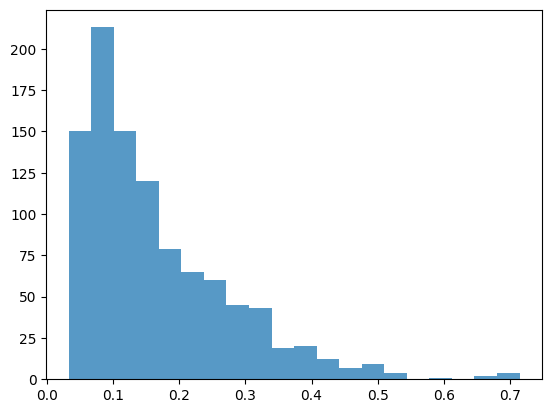

In [48]:
import math
### 遍历所有的数据集
index = 14070
counts = 2000
updata_list = []

for i in range(counts):
    up_data = dataset[i][1]
    if up_data[index] != 0:
        updata_list.append(math.fabs(up_data[index]))
    # break

import matplotlib.pyplot as plt
### 画一个频次图
plt.hist(updata_list, bins=20, alpha=0.75, log=False)
# plt.plot(updata_list)


(array([  43.,    0.,    0.,    0.,    6.,    7.,   30.,   40.,   63.,
          76.,  111.,  142.,  168.,  213.,  307.,  386.,  499.,  638.,
         711.,  853.,  912., 1005.,  989.,  953.,  897.,  788.,  688.,
         524.,  372.,  309.,  195.,  158.,   83.,   41.,   14.,   15.,
          18.,    5.,    0.,    3.]),
 array([0.00754166, 0.08264608, 0.15775051, 0.23285494, 0.30795937,
        0.38306379, 0.45816822, 0.53327265, 0.60837708, 0.6834815 ,
        0.75858593, 0.83369036, 0.90879478, 0.98389921, 1.05900364,
        1.13410807, 1.20921249, 1.28431692, 1.35942135, 1.43452578,
        1.5096302 , 1.58473463, 1.65983906, 1.73494349, 1.81004791,
        1.88515234, 1.96025677, 2.03536119, 2.11046562, 2.18557005,
        2.26067448, 2.3357789 , 2.41088333, 2.48598776, 2.56109219,
        2.63619661, 2.71130104, 2.78640547, 2.8615099 , 2.93661432,
        3.01171875]),
 <BarContainer object of 40 artists>)

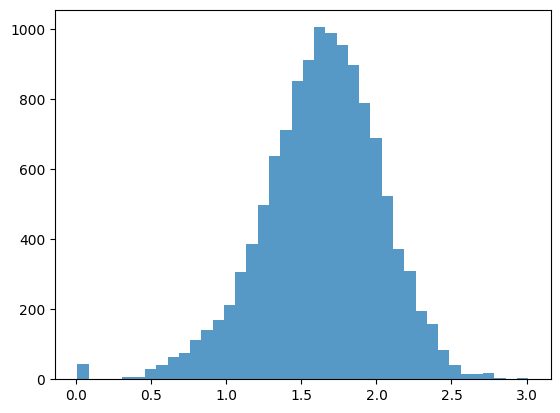

In [14]:
import math
### 遍历所有的数据集
index = 7048
counts = 12263
updata_list = []

for i in range(1,counts):
    up_data = dataset[i][1]
    updata_list.append(math.fabs(up_data[index]))
    # break

import matplotlib.pyplot as plt
### 画一个频次图
plt.hist(updata_list, bins=40, alpha=0.75)
# plt.plot(updata_list)


## 稀疏预测器

In [11]:
class SimpleLinearModel(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=32):
        super(SimpleLinearModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim,bias=False)
        # self.activation = nn.SiLU() # 添加激活函数
        self.linear2 = nn.Linear(hidden_dim,output_dim,bias=False)  
        init.kaiming_normal_(self.linear1.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.linear2.weight, mode='fan_out', nonlinearity='relu')
        # self.linear1.bias.data.fill_(0)
        # self.linear2.bias.data.fill_(0)

    def forward(self, x):
        # x= self.activation(x)
        return self.linear2(self.linear1(x))
    
model=SimpleLinearModel(4096,14336,hidden_dim=1024)
model.to("cuda")  # 假设使用 GPU
# criterion = nn.MSELoss().to("cuda")
criterion = nn.CrossEntropyLoss().to("cuda")
# criterion = nn.KLDivLoss(reduction='batchmean').to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4) #lr=5e-5
writer = SummaryWriter('runs/predictor_sparsity')

In [12]:
from tqdm import tqdm

cnt = 0

def sparse_row(row, keep_ratio=0.1, use_abs = False):
    # 计算需要保留的参数数量
    num_to_keep = int(keep_ratio * row.numel())
    
    # 找到绝对值最大的 num_to_keep 个参数的索引
    if use_abs:
        row = torch.abs(row)
    topk_indices = torch.topk(row, num_to_keep).indices
    # topk_indices = torch.topk(row, num_to_keep).indices
    
    # 创建一个与 row 相同大小的零张量
    sparse_row = torch.zeros_like(row)
    
    # 将 topk_indices 对应的值置为 1
    sparse_row[topk_indices] = 1
    
    return sparse_row

def generate_label(y, sparsity, use_abs=False):
    # 对每一行进行稀疏化
    sparse_tensor = torch.stack([sparse_row(row, sparsity, use_abs) for row in y])
    return sparse_tensor

def test_model(model, val_loader, sparsity=0.1):
    model.eval()
    # 初始化总的统计变量
    total_correct_preds = 0
    total_preds = 0
    total_labels = 0
    total_masks = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader)):
            with autocast():
                outputs = model(inputs)

            preds = generate_label(outputs, sparsity)
            truth = generate_label(targets, 0.1, use_abs = True)
            # truth = targets
            
            # 计算当前batch的精度
            dif = truth - preds
            miss = dif > 0.0 # classifier didn't activated target neuron

            total_correct_preds += (truth.sum(dim=1).float() - miss.sum(dim=1).float()).mean().item()
            total_preds += (preds.sum(dim=1).float()).mean().item()
            total_labels += (truth.sum(dim=1).float()).mean().item()

    # print('预测占比:{:.4f}'.format((total_preds/total_masks).item()))
    # print('标签占比:{:.4f}'.format((total_labels/total_masks).item()))
    print('预测与标签选取的数量比:',(total_preds / total_labels))
    print('覆盖率(Recall):',(total_correct_preds / total_labels))

def train_model(model, train_loader, val_loader, criterion, optimizer, writer, epochs=25, layerid=1):
    scaler = GradScaler()  # 创建 GradScaler 对象
    for epoch in range(epochs):
        if epoch % 2 == 0:
            print(f'---------after training {epoch} epochs---------')
            test_model(model, val_loader, sparsity=0.2)
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            targets = generate_label(targets, 0.2, use_abs =True)

            # 使用 autocast 来进行自动混合精度处理
            with autocast():
                outputs = model(inputs)
                probs = outputs.sigmoid()
                # cross_entropy
                loss = criterion(probs, targets)

            # 使用 GradScaler 来缩放损失，然后进行反向传播
            # 注意：反向传播不包含在 autocast() 块中
            scaler.scale(loss).backward()
            writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
            # 调用 scaler.step() 来更新模型权重，并调用 scaler.update() 准备下一步
            scaler.step(optimizer)
            scaler.update()
    print(f'---------after training {epochs} epochs---------')
    test_model(model, val_loader, sparsity=0.2)
    global cnt
    torch.save(model.state_dict(), f'./output/sparsity/{layerid}-{cnt}.pt')
    cnt += 1


In [4]:
for startid, endid in [(1,4),(4,7),(7,10)]:
    layerid = 15
    dataset = CustomDataset(layerid, startid=startid, endid=endid)
    print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
    # 划分训练集和验证集
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    train_model(model, train_loader, val_loader, criterion, optimizer, writer=writer, epochs=4, layerid=15)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


33it [00:08,  3.91it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.20009789296144784
---------after training 2 epochs---------


33it [00:07,  4.16it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5413863739824867
---------after training 4 epochs---------


33it [00:08,  4.11it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5608398667241754
327227 327227
327227 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


32it [00:07,  4.11it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5442518565676384
---------after training 2 epochs---------


32it [00:07,  4.15it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5660076314389747
---------after training 4 epochs---------


32it [00:07,  4.22it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5710160334627693
341549 341549
341549 torch.Size([4096]) torch.Size([14336])
---------after training 0 epochs---------


34it [00:08,  4.14it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5556886096016526
---------after training 2 epochs---------


34it [00:08,  4.22it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5726461708435582
---------after training 4 epochs---------


34it [00:08,  4.20it/s]


预测与标签选取的数量比: 2.0013956734124214
覆盖率(Recall): 0.5752094106414646


### 加载训练好的进行测试

In [13]:
layerid = 15
dataset = CustomDataset(layerid, startid=1, endid=4)
print(len(dataset), dataset[0][0].shape, dataset[0][1].shape) # torch.Size([512, 4096])
# 划分训练集和验证集
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
# model = SimpleLinearModel(4096,14336,hidden_dim=1024).cuda()
model.load_state_dict(torch.load(f'./output/sparsity/15-2.pt'))
test_model(model, val_loader, sparsity=0.3)

333186 333186
333186 torch.Size([4096]) torch.Size([14336])


33it [00:09,  3.30it/s]

预测与标签选取的数量比: 3.0006978367062107
覆盖率(Recall): 0.6927953512494317


### 下游任务测试

In [1]:
# Test Model
import os
import json
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
from convert_llama import convert_llama_model
os.environ["HF_ENDPOINT"]="https://hf-mirror.com"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from lm_eval.models.huggingface import HFLM
from lm_eval import evaluator


def _load_model(model_name = "Llama3-8b"):
    print(f"Loading model {model_name}")
    ### from path.json read paths of model and dataset
    with open('path.json', 'r') as file:
        paths = json.load(file)
        model_path = paths.get(model_name, '')

    model = LlamaForCausalLM.from_pretrained(
        model_path,
        device_map='auto',
        use_cache=True,
        torch_dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    return model, tokenizer

def evaluate(task_name, model, tokenizer, num_fewshot, device):
    hflm = HFLM(pretrained=model, tokenizer=tokenizer)
    results = evaluator.simple_evaluate(
    model=hflm,
    tasks=[task_name],
    num_fewshot=num_fewshot)
    print(results['results'])


def main(task_name, model_name, sparsity, start_num, end_num, token_sparsity, memory_limit, device, num_fewshot,):
    model, tokenizer = _load_model(model_name)
    
    model = convert_llama_model(model, sparsity, start_num, end_num, token_sparsity,)

    evaluate(task_name, model, tokenizer, num_fewshot, device)

main(task_name='boolq', model_name="Llama3-8b", sparsity=0.1, start_num=21, end_num=32, token_sparsity=0.1, memory_limit=0.1, device='cuda', num_fewshot=1)

KeyboardInterrupt: 